# Ridge Regression and K-Fold Cross Validation
Derek Wayne

February 12, 2019

## Ridge Regression Estimates

The standard model for regression analysis is given by $y = f(\mathbf{x}) + \epsilon$, where $\epsilon \sim \mathcal{N}(0, \sigma^2)$. The regression function: $\hat{f}(\mathbf{x})=\mathbf{x}^T\widehat{\beta}$. The ordinary least squares estimate for $\widehat{\beta}$ has variance: $\sigma^2(X^TX)^{-1}$. The more features we include in the model increases the complexity. This may cause the variance of the coefficient estiamtes to blow up. Prediction error can be mitigated by introducing bias into the model. This leads to regularization of the $\widehat{\beta}$s. There exist a few effective approaches here. Consider imposing a multivariate Guassian prior on the model estimates:
$$
p(\beta) = \frac{1}{\sqrt{2\pi\tau^2}}I\,exp\{-\frac{1}{2\tau^2}I\beta^T\beta \}
$$
then we may find the maximum a posteriori estimates as follows,
$$
\widehat{\beta}_{MAP} := arg\max_{\beta}\bigg(\prod_{i=1}^np(y_i | x_i, \beta) \bigg)p(\beta)
$$
with log-likelihood given by,
$$
\ell(\beta) = \sum_{i=1}^nlog\,\,p(y_i | x_i, \beta) -\frac{1}{2\tau^2}I\beta^T\beta + k
$$
(where k is a constant independent of $\beta$) and thus likelihood equation:
$$
\frac{1}{\sigma^2}(X^TX)\beta + \frac{1}{\tau^2}I\beta = \frac{1}{\sigma^2}X^Ty \\
\iff \\
\big(X^TX + \lambda I \big)\beta = X^Ty
$$
which can be seen as the ridge estimates. Another approach is the so-called "data augmentation" approach.
Define: $X_{\lambda} = \biggl[\begin{matrix} X_{n \times m} \\ D_{\lambda} \end{matrix} \biggr]$ where $D_{\lambda} = diag(\sqrt{\lambda})$ or $\sqrt{\lambda}I_m$; and define $y_{\lambda} = (y \, | \, 0)^T$ with $0 \in \mathbb{R}^m$. Then
$$
\begin{aligned}
\widehat{\beta}_{RIDGE} &= (X_{\lambda}^TX_{\lambda})^{-1}X_{\lambda}^Ty \\
&= \bigg[(X^T, \sqrt{\lambda}I_m) \biggl( \begin{matrix} X \\ \sqrt{\lambda}I_m \end{matrix} \biggr) \bigg]^{-1}(X^T, \sqrt{\lambda}I_m)\biggl(\begin{matrix}y \\ 0 \end{matrix}\biggr) \\
&= (X^TX + \lambda I_m)^{-1}X^Ty
\end{aligned}
$$

## K-Fold Cross Validation

In order to implement k-fold cross validation we will need functions to:
1. Shuffle the data set
2. Split the dataset into k groups
3. Within each group:
    1. Select one as holdout set
    2. Use the remaining sets for training
    3. Train a model with the training set and evaluate on the test set
    4. Save the evaluation metric and discard the model.
4. Summarize the performance of the model based on the vector of values produced by step 3.

We begin by importing the necessary packages and the complete dataset (which is store as a list of matrices).

In [15]:
suppressMessages(library(R.matlab))
dataset <- readMat('dataset.mat')
train <- dataset[c('data.train.y', 'data.train.X')]
train$data.train.y <- t(train$data.train.y) # make target into column vector
test <- dataset[c('data.test.y', 'data.test.X')]
test$data.test.y <- t(test$data.test.y)

Next we create a function that will permute the dataset (shuffle).

In [16]:
set.seed(727)
shuffle_data <- function(data) {
  data <- cbind(data[[1]], data[[2]]) # preserve target-feature pairs
  data <- data[sample(nrow(data)),]
  list(data[,1], data[,2:ncol(data)]) # separate target and design for continuity
}

Next we will need to create k partition of the data. A function to do this:

In [17]:
split_data <- function(data, num_folds, fold) {
  data <- cbind(data[[1]], data[[2]])
  tmp <- lapply(seq(1, nrow(data), ceiling(nrow(data)/num_folds)),
                function(i) data[i:min(i + ceiling(nrow(data)/num_folds) - 1, nrow(data)),])
  data_fold <- tmp[[fold]]
  data_rest <- do.call(rbind, tmp[-fold])
  r <- list("data_fold" = list("data.y"=matrix(data_fold[,1], byrow = T),
                               "data.X"=data_fold[,2:ncol(data_fold)]),
            "data_rest" = list("data.y"=matrix(data_rest[,1], byrow = T),
                               "data.x"=data_rest[,2:ncol(data_rest)]))
  r
}

To train a model on the training sets using the ridge estimator $\widehat{\beta}_{RIDGE} = (X_{\lambda}^TX_{\lambda})^{-1}X_{\lambda}^Ty$ as derived earlier; and a loss function: $\|\mathbf{y} - X^T \widehat{\beta} \|^2$ to be minimized.

In [18]:
train_model <- function(data, lambd) {
  X <- data[[2]]
  y <- data[[1]]
  solve(t(X) %*% X + lambd * diag(nrow=ncol(X))) %*% t(X) %*% y # ridge estimate
}
loss <- function(data, model) {
  X <- data[[2]]
  y <- data[[1]]
  t(y - X %*% model) %*% (y - X %*% model) / nrow(X)
}

and finally a function to perform the k-fold cross validation:

In [19]:
cross_validation <- function(data, num_folds, lambd_seq) {
  data = shuffle_data(data)
  cv_error <- numeric(length(lambd_seq))
  for (i in 1:length(lambd_seq)) {
    lambd <- lambd_seq[i]
    cv_loss_lmd <- 0
    for (fold in 1:num_folds) {
      tmp <- split_data(data, num_folds = num_folds, fold = fold)
      val_cv <- tmp$data_fold
      train_cv <- tmp$data_rest
      model <- train_model(train_cv, lambd)
      cv_loss_lmd <- cv_loss_lmd + loss(val_cv, model)
    }
    cv_error[i] <- cv_loss_lmd / num_folds
  }
  cv_error
}

To find the optimal penalty paramter $\lambda$ we will compare the training error, test error, 5-fold cross validation and 10-fold cross validation.

In [20]:
lambd_seq <- seq(0.02, 1.5, length.out = 50) # a sequence of lambda values

training_error <- numeric(length(lambd_seq))
for (i in 1:length(lambd_seq)) {
  model <- train_model(train, lambd_seq[i])
  error <- loss(train, model)
  training_error[i] <- error
}

test_error <- numeric(length(lambd_seq))
for (i in 1:length(lambd_seq)) {
  model <- train_model(train, lambd_seq[i])
  error <- loss(test, model)
  test_error[i] <- error
}

cv_error1 <- cross_validation(train, 5, lambd_seq = lambd_seq) # 5 folds
cv_error2 <- cross_validation(train, 10, lambd_seq = lambd_seq) # 10 folds

To compare we will load in the ggplot2 package and plot the error lines on the same plot.

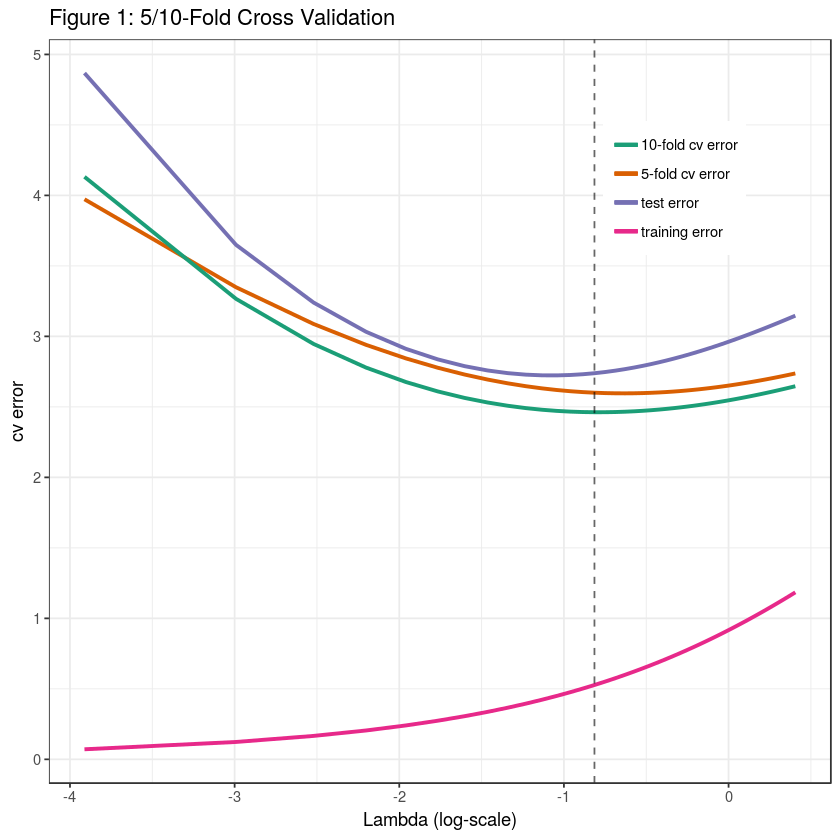

In [23]:
library(ggplot2)
error_df <- data.frame("training_error" = training_error,
                       "test_error" = test_error,
                       "cv_error1" = cv_error1,
                       "cv_error2" = cv_error2,
                       "lambdas" = lambd_seq)

p1 <- ggplot(data=error_df, aes(x=log(lambdas), y=training_error)) +
  geom_line(aes(col="training error"), size = 1.1)
p2 <- geom_line(aes(y = test_error, col="test error"), size = 1.1)
p3 <- geom_line(aes(y = cv_error1, col="5-fold cv error"), size = 1.1)
p4 <- geom_line(aes(y = cv_error2, col="10-fold cv error"), size = 1.1)
p1 + p2 + p3 + p4 +
  labs(x="Lambda (log-scale)", y = "cv error",
       title = "Figure 1: 5/10-Fold Cross Validation") +
  theme_bw() +
  theme(legend.position = c(0.8, 0.8), legend.title = element_blank()) +
  scale_color_brewer(palette = "Dark2") +
  geom_vline(aes(xintercept = log(lambdas[which.min(cv_error2)])), alpha = 0.6, linetype="dashed")

## Results

In $\textbf{Figure 1}$ above $\lambda^*=0.442$ (shown by the dashed verticle line) was selected as the minimizer of the 10-fold cross validaton error. Between the 10-fold and 5-fold cross validation errors, both models perform similarly for small values of $\lambda$ (i.e. parameter estimates that are 'close' to the ordinary least squares estimates). On the other hand, the training error is significantly lower due to the fact that it was tested on the same set it learned from (overfitting). This model would thus generalize poorly; evidenced by the test error, which is greater than the errors for our cross validation models.